In [1]:
from utils import *
from tqdm.auto import tqdm
from SALib.analyze import pawn, morris
from scipy.signal import correlate
from scipy.spatial import ConvexHull
from scipy.spatial import Delaunay
import numpy as np
import seaborn as sns
from ripser import ripser
import pandas as pd
import pickle
import time
import os
from scipy import signal as sp_signal
from scipy.stats import binned_statistic_2d
from scipy.stats import gaussian_kde
from collections import Counter
import networkx as nx

import warnings
warnings.filterwarnings("ignore")

import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
import matplotlib.patches as patches
from matplotlib.colors import Normalize
plt.rcParams.update(plt.rcParamsDefault)
plt.rcParams.update({"font.size" : 15,
                     "figure.dpi" : 100, 
                     "grid.alpha" : 0.3, 
                     "axes.grid": False, 
                     "axes.axisbelow" : True,
                     "figure.figsize":(8,6),
                     "mathtext.fontset":"cm",
                     "xtick.labelsize": 14,
                     "ytick.labelsize": 14,
                     "axes.labelsize": 16, 
                     "legend.fontsize": 13.5})
plt.rc("text", usetex=False)
plt.rc("font", family="serif")

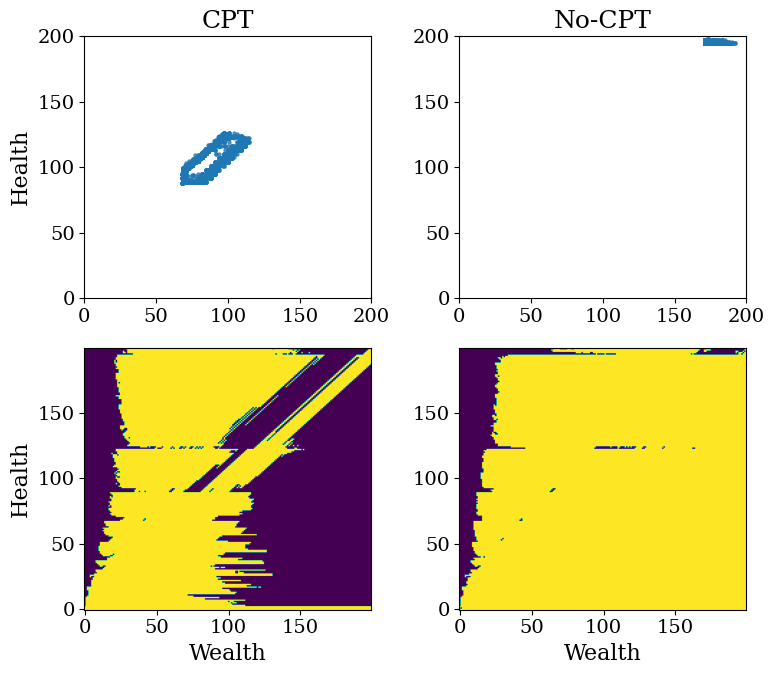

In [30]:
IDX = 547

fig, axs = plt.subplots(2, 2, figsize=(8,7))

cpt_P = None
nocpt_P = None

for idx, d in enumerate(["cpt/", "nocpt/"]):
    for i, file in enumerate(sorted(os.listdir(d))):
        if i == IDX:
            with open(d+file, "rb") as f:
                res = pickle.load(f)
            P = res["policy"]
            if d=="cpt/":
                cpt_P = P
                cpt_f = d+file
            else:
                nocpt_P = P
                nocpt_f = d+file
            break
    axs[0][idx].scatter(
        res["wealth"][:,-1],
        res["health"][:,-1],
        s=5,
        alpha=0.7
    )
    axs[0][idx].set_xlim(0,200)
    axs[0][idx].set_ylim(0,200)
    axs[1][idx].imshow(P.T, origin="lower", aspect="auto")

axs[0][0].set_title("CPT")
axs[0][1].set_title("No-CPT")
axs[0][0].set_ylabel("Health")
axs[1][0].set_ylabel("Health")

axs[1][0].set_xlabel("Wealth")
axs[1][1].set_xlabel("Wealth")

fig.tight_layout()
plt.show()

In [13]:
A = res["params"]["w_delta_scale"]
alpha = res["params"]["alpha"]
P_H_decrease = res["params"]["P_H_decrease"]
P_H_increase = res["params"]["P_H_increase"]

w_init = 20
h_init = 20

cpt_agent = (w_init, h_init)
cpt_util = [utility(w_init, h_init, alpha)]
cpt_pos = []

nocpt_agent = (w_init, h_init)
nocpt_util = [utility(w_init, h_init, alpha)]
nocpt_pos = []

num_steps = 5000

for s in tqdm(range(num_steps)):

    RN = np.random.uniform(0,1,1)

    # CPT
    w, h = cpt_agent
    w = int(w)
    h = int(h)
    cpt_decision = cpt_P[w-1, h-1]
    invest_cost = compute_health_cost(h)
    health_delta = compute_health_delta(h)

    if cpt_decision == 1 and w > invest_cost:
        new_w = compute_new_wealth(w-invest_cost, A, utility(w-invest_cost, h, alpha), 200)
        new_h = h
        if RN < P_H_increase:
            new_h = min(h + health_delta, 200)
        cpt_agent = (new_w, new_h)
        cpt_util.append(utility(new_w, new_h, alpha))
        cpt_pos.append(cpt_agent)
    else:
        new_w = compute_new_wealth(w, A, utility(w, h, alpha), 200)
        new_h = h
        if RN < P_H_decrease:
            new_h = max(1, h - health_delta)
        cpt_agent = (int(new_w), int(new_h))
        cpt_util.append(utility(new_w, new_h, alpha))
        cpt_pos.append(cpt_agent)
            
    # No CPT
    w, h = nocpt_agent
    w = int(w)
    h = int(h)
    nocpt_decision = nocpt_P[w-1, h-1]
    invest_cost = compute_health_cost(h)
    health_delta = compute_health_delta(h)

    if nocpt_decision == 1 and w > invest_cost:
        new_w = compute_new_wealth(w-invest_cost, A, utility(w-invest_cost, h, alpha), 200)
        new_h = h
        if RN < P_H_increase:
            new_h = min(h + health_delta, 200)
        nocpt_agent = (new_w, new_h)
        nocpt_util.append(utility(new_w, new_h, alpha))
        nocpt_pos.append(nocpt_agent)
    else:
        new_w = compute_new_wealth(w, A, utility(w, h, alpha), 200)
        new_h = h
        if RN < P_H_decrease:
            new_h = max(1, h - health_delta)
        nocpt_agent = (int(new_w), int(new_h))
        nocpt_util.append(utility(new_w, new_h, alpha))
        nocpt_pos.append(nocpt_agent)

  0%|          | 0/5000 [00:00<?, ?it/s]

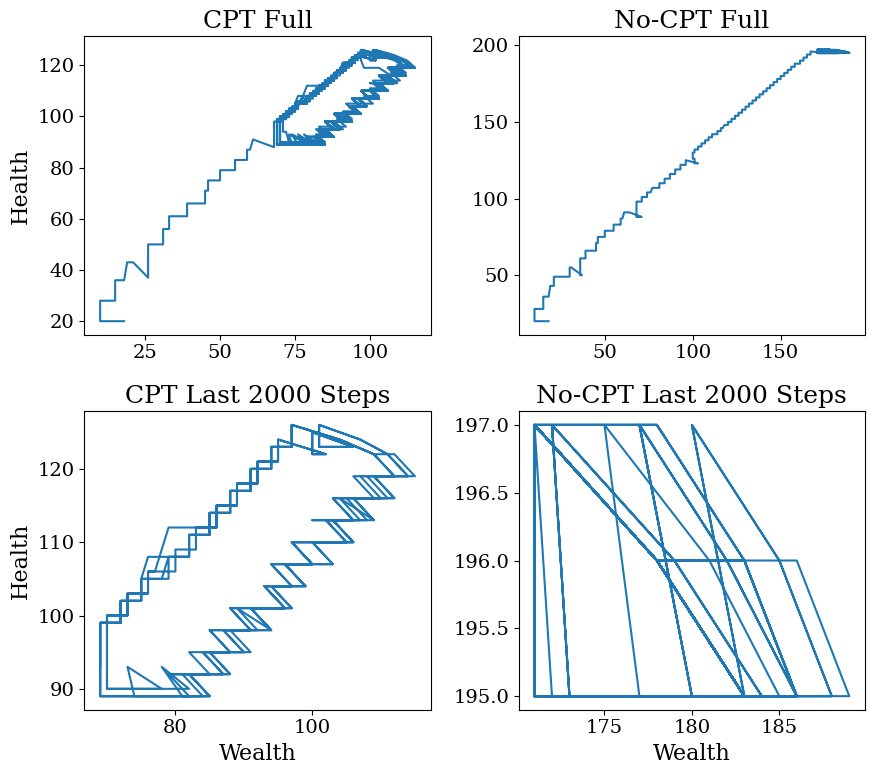

In [14]:
fig, axs = plt.subplots(2, 2, figsize=(9,8))

timesteps = [num_steps, 2000]

for j, t in enumerate(timesteps):
    for i, arr in enumerate([cpt_pos, nocpt_pos]):
        axs[j][i].plot(
            [x[0] for x in arr[-t:]],
            [x[1] for x in arr[-t:]],
        )

axs[0][0].set_ylabel("Health")
axs[1][0].set_ylabel("Health")
axs[1][0].set_xlabel("Wealth")
axs[1][1].set_xlabel("Wealth")

axs[0][0].set_title("CPT Full")
axs[1][0].set_title(f"CPT Last {timesteps[-1]} Steps")
axs[0][1].set_title("No-CPT Full")
axs[1][1].set_title(f"No-CPT Last {timesteps[-1]} Steps")

fig.tight_layout()
plt.show()

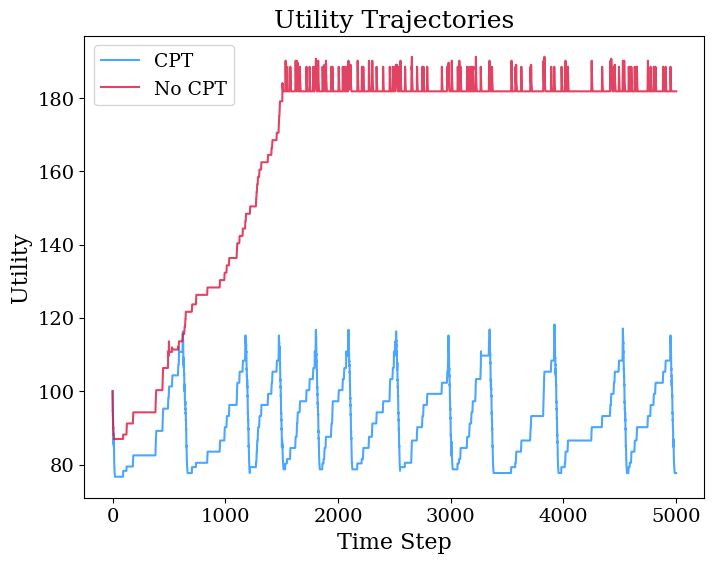

In [5]:
plt.plot(cpt_util, alpha=0.8, label="CPT", color="dodgerblue")
plt.plot(nocpt_util, alpha=0.8, label="No CPT", color="crimson")
plt.legend()

plt.title("Utility Trajectories")
plt.xlabel("Time Step")
plt.ylabel("Utility")
plt.show()

In [10]:
def load_pickle(path):
    with open(path, "rb") as f:
        return pickle.load(f)

def analyze_graph(G):
    """
    Compute basic graph diagnostics for dynamics.
    """
    metrics = {}
    metrics["num_nodes"] = len(G)
    metrics["num_edges"] = G.number_of_edges()
    metrics["avg_out_degree"] = np.mean([d for _, d in G.out_degree()])
    metrics["num_scc"] = nx.number_strongly_connected_components(G)
    metrics["largest_scc_size"] = len(max(nx.strongly_connected_components(G), key=len))
    metrics["avg_clustering"] = nx.average_clustering(G.to_undirected())
    return metrics
 
def visualize_graph(G):
    """
    Visualize a subset of the state graph, emphasizing strong transitions.
    """
    plt.figure(figsize=(8, 8))
    edges_sorted = sorted(G.edges(data=True), key=lambda e: e[2]["weight"], reverse=True)
    subG = nx.DiGraph()
    for u, v, d in edges_sorted:
        subG.add_edge(u, v, weight=d["weight"])

    pos = {n: (n[0], n[1]) for n in subG.nodes()}
    weights = [d["weight"] for _, _, d in subG.edges(data=True)]
    nx.draw(
        subG,
        pos,
        node_size=5,
        edge_color=weights,
        edge_cmap=plt.cm.plasma,
        arrowsize=4,
        with_labels=False,
    )
    plt.xlabel("Wealth")
    plt.ylabel("Health")
    plt.title("State Transition Graph (Top Edges)")
    plt.show()

def build_state_graph(res, discard_steps=1000, min_edge_weight=5):
    """
    Build a directed graph of (wealth, health) transitions from all agent trajectories.
    Track which agents traverse each edge.
    """
    wealth = res["wealth"][:, discard_steps:]
    health = res["health"][:, discard_steps:]

    G = nx.DiGraph()
    num_agents, num_steps = wealth.shape

    # Collect transitions
    for agent_id in tqdm(range(num_agents), desc="Building transitions"):
        w_seq = wealth[agent_id]
        h_seq = health[agent_id]
        for t in range(num_steps - 1):
            s_from = (int(w_seq[t]), int(h_seq[t]))
            s_to   = (int(w_seq[t + 1]), int(h_seq[t + 1]))
            if s_from == s_to:
                continue
            if G.has_edge(s_from, s_to):
                G[s_from][s_to]["weight"] += 1
                G[s_from][s_to]["agents"].add(agent_id)
            else:
                G.add_edge(s_from, s_to, weight=1, agents={agent_id}) # each agent can contribute a max weight of 1 per transition, even if done multiple times

    # Filter low-frequency edges
    to_remove = [(u, v) for u, v, d in G.edges(data=True) if d["weight"] < min_edge_weight]
    G.remove_edges_from(to_remove)

    print(f"Graph built with {len(G.nodes)} nodes and {len(G.edges)} edges after filtering.")
    return G

Building transitions:   0%|          | 0/10000 [00:00<?, ?it/s]

Graph built with 726 nodes and 696 edges after filtering.

Graph Metrics:
num_nodes                : 726
num_edges                : 696
avg_out_degree           : 0.9586776859504132
num_scc                  : 236
largest_scc_size         : 491
avg_clustering           : 0.04178145087235996


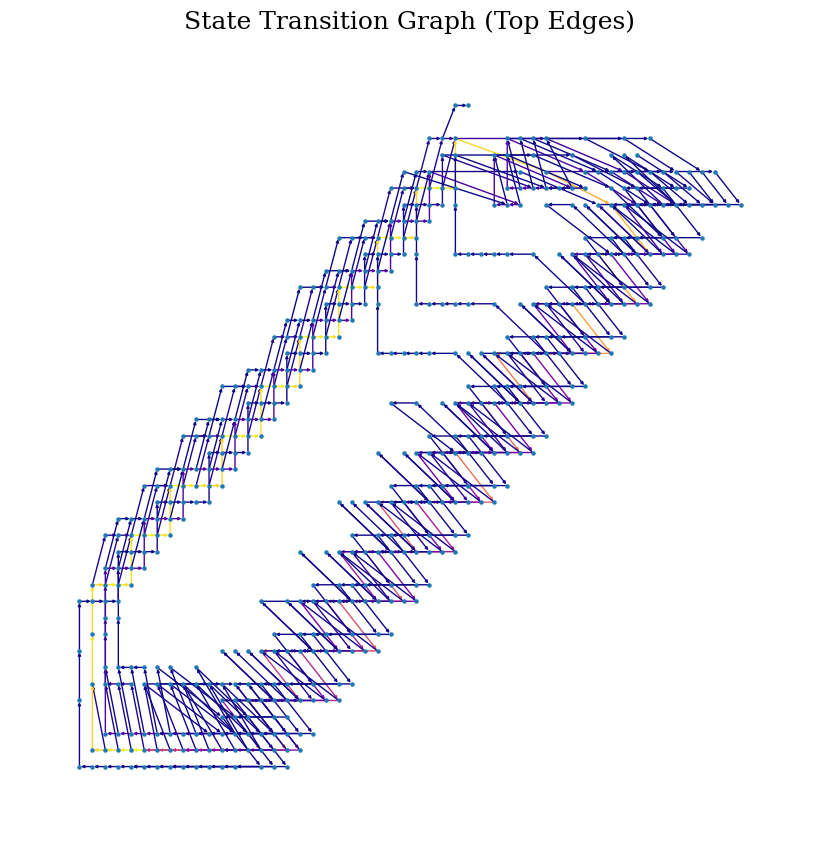

In [11]:
pkl = cpt_f
res = load_pickle(pkl)
G = build_state_graph(res, discard_steps=2000, min_edge_weight=100)
metrics = analyze_graph(G)
print("\nGraph Metrics:")
for k, v in metrics.items():
    print(f"{k:25s}: {v}")
visualize_graph(G)

Building transitions:   0%|          | 0/10000 [00:00<?, ?it/s]

Graph built with 214 nodes and 158 edges after filtering.

Graph Metrics:
num_nodes                : 214
num_edges                : 158
avg_out_degree           : 0.7383177570093458
num_scc                  : 158
largest_scc_size         : 57
avg_clustering           : 0.011838006230529595


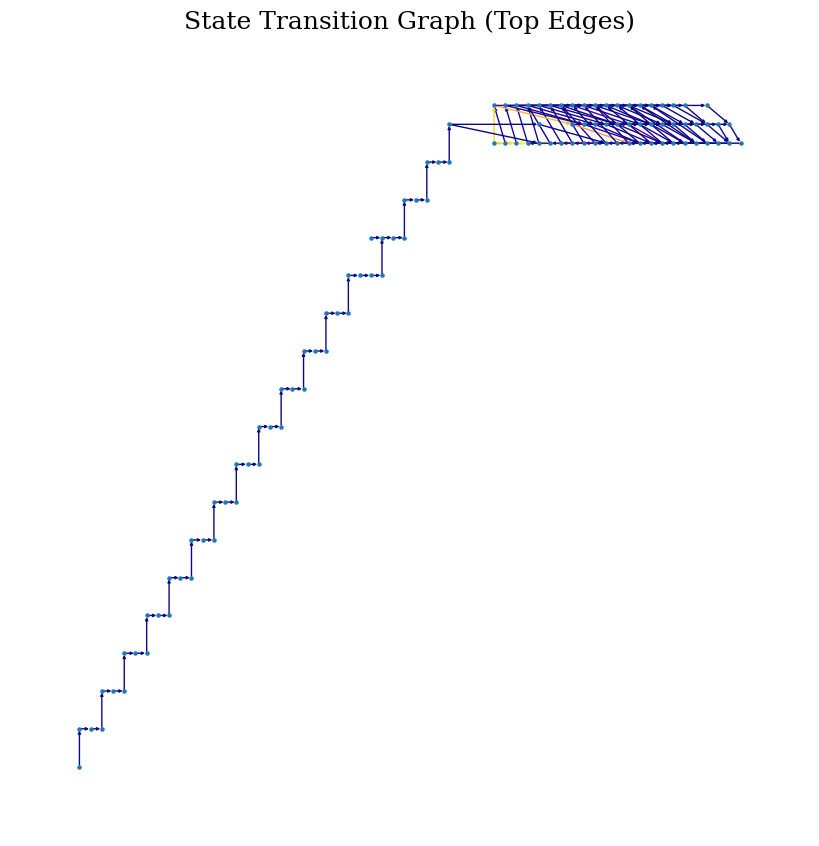

In [12]:
pkl = nocpt_f
res = load_pickle(pkl)
G = build_state_graph(res, discard_steps=2000, min_edge_weight=100)
metrics = analyze_graph(G)
print("\nGraph Metrics:")
for k, v in metrics.items():
    print(f"{k:25s}: {v}")
visualize_graph(G)